In [ ]:
# Installations
!pip install xgboost
!pip install catboost
!pip install tabulate
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 8.1 MB/s eta 0:00:00


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score #score evaluation
import shap

from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
# Connects to google-drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# File upload from GoogleDrive into pandas DataFrame
df = pd.read_excel("/content/drive/MyDrive/Final Project Assets/BankersExtractedData.xlsx")

In [ ]:
# X and Y process
y_df = df.iloc[:,-1].values
x_df = df.drop(['Unnamed: 0','ID',"Filename", "Label"], axis=1, inplace=False)

# Normalize with StandardScaler
stdsc = StandardScaler()
x_std = stdsc.fit_transform(x_df)

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x_std, y_df, test_size = 0.20)



---



In [ ]:
# Feature Importance Presentation
def featureImportanceDictionary(lst):
  """
  Creates a dictionary of the labels of the features with the scores they have listed after calculations.

  Args:
    lst (list): List of scores of the feature importance calculations.

  Returns:
    A dictionary of feature labels as keys and scores as values.
  """
  labeled_feature_importance = {}
  for i in range(len(lst)):
    labeled_feature_importance[x_df.columns[i]] = lst[i]
  return labeled_feature_importance

In [ ]:
def sortDictionaryDesc(dic):
  """
  Sorts a dictionary in a descending order

  Args:
    dic (dictionary) - dictionary with values to sort.

  Returns:
    Sorted dictionary in a descending order. 
  """
  sort_data = {}
  while(len(dic) > 0):
    cur_key = ""
    min = -sys.maxsize
    for i in dic:
      if(dic[i] >= min):
        min = dic[i]
        cur_key = i
    dic.pop(cur_key)
    sort_data[cur_key] = min
  return sort_data

In [ ]:
def sortDictionaryAsc(dic):
  """
  Sorts a dictionary in an ascending order

  Args:
    dic (dictionary) - dictionary with values to sort.

  Returns:
    Sorted dictionary in an ascending order. 
  """
  sort_data = {}
  while(len(dic) > 0):
    cur_key = ""
    max = sys.maxsize
    for i in dic:
      if(dic[i] <= max):
        max = dic[i]
        cur_key = i
    dic.pop(cur_key)
    sort_data[cur_key] = max
  return sort_data

In [ ]:
def FeatureImportance(lst):
  """
  Create a descending sorted dictionary of the feature importance results.

  Args:
    lst (list): Of the calculated scores of the features importance.

  Returns:
    A descending sorted dictionary of the features and their scores.
  """
  data = featureImportanceDictionary(lst)
  sorted_data = sortDictionaryDesc(data)
  return sorted_data


In [ ]:
def printDataWithValue(dic):
  """
  Prints Key:Value pairs from a dictionary in a specific format.

  Args:
    dic (dictionary)- dictionary with key:value pairs.

  Returns:
    None.
  """
  cols = x_df.columns.to_list()
  counter = 0
  for k,v in dic.items():
    counter += 1
    print(f"{counter}. {k} [{cols.index(k)}]: {v}")

In [ ]:
def printDataNoValue(dic):
  """
  Prints Keys from a dictionary in a specific format.

  Args:
    dic (dictionary)- Dictionary to print the keys from.

  Returns:
    None.
  """
  cols = x_df.columns.to_list()
  counter = 0
  for k in dic.keys():
    counter += 1
    print(f"{counter}. {k} [{cols.index(k)}]")

---
# First Step
The same code from the first colab notebook.
First testing of:

* Random Forest Classifier.
* Cat Boost Classifier.
* XGBoost Classifier.


In [ ]:
# K-Fold Models testing
kfold = KFold(n_splits=5)
Means=[]
accuracy=[]
std=[]
classifiers = ['Random Forest Classifier',
               'Cat Boost Classifier',
               'XGBClassifier']

models = [RandomForestClassifier(n_estimators=100),
          CatBoostClassifier(iterations=20, learning_rate=1, depth=2),
          XGBClassifier(objective='binary:logistic',nthread=4,seed=42)]

for i in models:
    model = i
    cv_result = cross_val_score(model,x_train,y_train, cv = kfold,scoring = "accuracy")
    Means.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)

models_dataframe=pd.DataFrame({'CV Mean':Means,'Std':std},index=classifiers)  
models_dataframe 

---
# Classification Reports and Confusion Matrices
In this part we used the trained models we trained in the first notebook, in order to create classification reports and confusion matrices and learn more about the results and the result they were the results.


# Feature Importance
On the trained models and the results they produced, we now want to learn the relations between the features and the results, and eventually between the relations and the status we labeled the participants in this experiment.

On the trained models that aren't neural network models, we used a property they have that's called feature_importances_ .

On the neural networks the method was a bit different, an explantion of it is found below.

The feature's importance was calculated in 3 steps overall:
1. Feature importance calculation and graph display for each model.
2. Sorted list display of labels and results for each model.
3. Overall calculation of the results from all models and it's display.

### XGBoost

---



In [ ]:
# XGBoost Hyperparameters Tuning
XGB_parameters = {'gamma': [0.01,0.05,0.1,0.2,0.5,1,1.5,2,2.5,3,3.5,5,10],
              'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2,0.25,0.3,0.35,0.4, 0.5,0.55,0.6,0.75],
              'max_depth': [2,3,4,5,6,7,8,9,10,11,12],
              'n_estimators': [4,6,8,9,10,15,20,35,50,65,80,100]
             }

XGB=XGBClassifier(n_jobs=-1)

xgb_grid = GridSearchCV(estimator=XGB, param_grid=XGB_parameters, n_jobs=-1, cv=2, scoring='roc_auc')
xgb_grid.fit(x_train,y_train)


print("Results from Grid Search XGboost:\n")
print(f"\n The best score across ALL searched params:\n{xgb_grid.best_score_}\n")
print(f"\n The best parameters across ALL searched params:\n{xgb_grid.best_params_}\n")

for XGBoost model:
 Train Accuracy:  85.473411154345 ; Test Accuracy: 83.7651122625216

Train Matrix:
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86      1158
         1.0       0.86      0.85      0.85      1155

    accuracy                           0.85      2313
   macro avg       0.85      0.85      0.85      2313
weighted avg       0.85      0.85      0.85      2313


Test Matrix:
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84       288
         1.0       0.85      0.82      0.84       291

    accuracy                           0.84       579
   macro avg       0.84      0.84      0.84       579
weighted avg       0.84      0.84      0.84       579




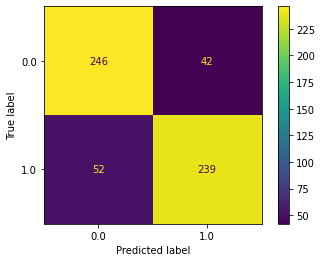

In [ ]:
# XGBoost Best Params : Classification-Report & Confusion-Matrix
XGB = XGBClassifier(n_jobs=-1,gamma=1.5, learning_rate=0.5 , max_depth=2,n_estimators=8).fit(x_train,y_train)

xgb_predict_train = XGB.predict(x_train)
train_accuracy = accuracy_score(y_train,xgb_predict_train)*100

xgb_predict_test = XGB.predict(x_test)
test_accuracy = accuracy_score(y_test,xgb_predict_test)*100

print(f"for XGBoost model:\n Train Accuracy:  {train_accuracy} ; Test Accuracy: {test_accuracy}\n")

print(f"Train Matrix:\n{classification_report(y_train,xgb_predict_train)}\n")
print(f"Test Matrix:\n{classification_report(y_test,xgb_predict_test)}\n")

confusion_matrix = metrics.confusion_matrix(y_test,xgb_predict_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0.0, 1.0])

cm_display.plot()
plt.show()

Feature: 0, Score: 0.11541
Feature: 1, Score: 0.13092
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.04688
Feature: 5, Score: 0.45722
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00452
Feature: 8, Score: 0.05793
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.02325
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.05628
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.05646
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.05114
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000


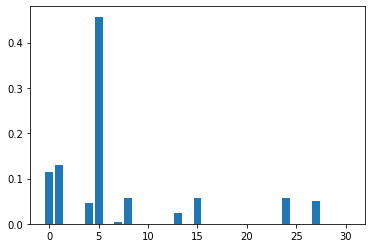

In [ ]:
# get feature importance for XGB model
importance = XGB.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
XGB_Importance = FeatureImportance(importance.tolist())
printDataWithValue(XGB_Importance)

1. Avg_Sentence_Length [5]: 0.4572213590145111
2. Negative [1]: 0.13091742992401123
3. Neutral [0]: 0.1154087483882904
4. Amp_Env_Min [8]: 0.05792849883437157
5. Mel_Spec_STD [24]: 0.05645658075809479
6. RMS_Median [15]: 0.0562785379588604
7. MFCC_Max [27]: 0.051142867654561996
8. Avg_Word_Duration [4]: 0.0468757227063179
9. RMS_Min [13]: 0.023254089057445526
10. Amp_Env_Max [7]: 0.0045161135494709015
11. MFCC_Median [30]: 0.0
12. MFCC_STD [29]: 0.0
13. MFCC_Min [28]: 0.0
14. MFCC_Avg [26]: 0.0
15. Mel_Spec_Median [25]: 0.0
16. Mel_Spec_Min [23]: 0.0
17. Mel_Spec_Max [22]: 0.0
18. Mel_Spec_Avg [21]: 0.0
19. ZCR_Median [20]: 0.0
20. ZCR_STD [19]: 0.0
21. ZCR_Min [18]: 0.0
22. ZCR_Max [17]: 0.0
23. ZCR_Avg [16]: 0.0
24. RMS_STD [14]: 0.0
25. RMS_Max [12]: 0.0
26. RMS_Avg [11]: 0.0
27. Amp_Env_Median [10]: 0.0
28. Amp_Env_STD [9]: 0.0
29. Amp_Env_Avg [6]: 0.0
30. Avg_Sentence_Duration [3]: 0.0
31. Positive [2]: 0.0


### CatBoost

---



In [ ]:
# CatBoost Hyperparameters Tuning

Cat_parameters = {'depth'         : [2,3,4,5,6,7,8,9,10],
                 'learning_rate' : [0.0001,0.001,0.01,0.1,1,1.2,1.5,2,2.5],
                  'iterations'    : [4,6,8,10,20,30,40,50,60,70,80,90,100]}

CBC = CatBoostClassifier()
cbc_grid = GridSearchCV(estimator=CBC, param_grid = Cat_parameters, cv = 2, n_jobs=-1)
cbc_grid.fit(x_train,y_train)


print("\nResults from Grid Search CatBoost:\n")
print(f"\n The best score across ALL searched params:\n{cbc_grid.best_score_}\n")
print(f"\n The best parameters across ALL searched params:\n{cbc_grid.best_params_}\n")

0:	learn: 0.6356886	total: 16.3ms	remaining: 1.94s
1:	learn: 0.5885425	total: 35.2ms	remaining: 2.08s
2:	learn: 0.5504981	total: 52.8ms	remaining: 2.06s
3:	learn: 0.5136311	total: 69.8ms	remaining: 2.02s
4:	learn: 0.4851075	total: 86.3ms	remaining: 1.99s
5:	learn: 0.4610999	total: 103ms	remaining: 1.95s
6:	learn: 0.4390378	total: 118ms	remaining: 1.91s
7:	learn: 0.4255925	total: 136ms	remaining: 1.91s
8:	learn: 0.4115963	total: 151ms	remaining: 1.86s
9:	learn: 0.3946512	total: 165ms	remaining: 1.81s
10:	learn: 0.3854788	total: 187ms	remaining: 1.86s
11:	learn: 0.3756752	total: 216ms	remaining: 1.94s
12:	learn: 0.3674400	total: 244ms	remaining: 2s
13:	learn: 0.3589295	total: 264ms	remaining: 2s
14:	learn: 0.3515164	total: 291ms	remaining: 2.04s
15:	learn: 0.3469071	total: 318ms	remaining: 2.07s
16:	learn: 0.3414590	total: 340ms	remaining: 2.06s
17:	learn: 0.3382749	total: 355ms	remaining: 2.01s
18:	learn: 0.3331140	total: 377ms	remaining: 2s
19:	learn: 0.3304414	total: 407ms	remaining: 

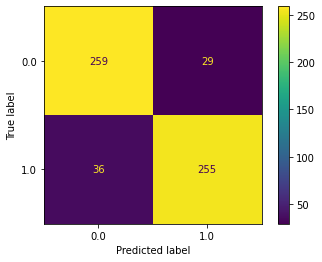

In [ ]:
# CatBoost Best Params : Classification-Report & Confusion-Matrix

CBC = CatBoostClassifier(depth=5, iterations=120 , learning_rate=0.1).fit(x_train,y_train)

cbc_predict_train=CBC.predict(x_train)
train_accuracy=accuracy_score(y_train,cbc_predict_train)*100

cbc_predict_test=CBC.predict(x_test)
test_accuracy=accuracy_score(y_test,cbc_predict_test)*100

print(f"for CatBoost model:\Train Accuracy: {train_accuracy} ; Test Accuracy: {test_accuracy}\n")

print(f"Train Matrix:\n{classification_report(y_train,cbc_predict_train)}\n")
print(f"Test Matrix:\n{classification_report(y_test,cbc_predict_test)}\n")

confusion_matrix = metrics.confusion_matrix(y_test,cbc_predict_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0.0, 1.0])

cm_display.plot()
plt.show()

Feature: 0, Score: 5.98229
Feature: 1, Score: 19.26605
Feature: 2, Score: 2.42375
Feature: 3, Score: 5.56854
Feature: 4, Score: 5.17528
Feature: 5, Score: 28.89951
Feature: 6, Score: 1.35233
Feature: 7, Score: 1.02116
Feature: 8, Score: 2.23179
Feature: 9, Score: 1.53208
Feature: 10, Score: 0.82991
Feature: 11, Score: 0.30606
Feature: 12, Score: 0.89738
Feature: 13, Score: 2.45470
Feature: 14, Score: 0.65947
Feature: 15, Score: 3.58359
Feature: 16, Score: 1.90384
Feature: 17, Score: 1.44207
Feature: 18, Score: 0.71450
Feature: 19, Score: 0.37853
Feature: 20, Score: 1.14276
Feature: 21, Score: 1.88491
Feature: 22, Score: 0.12794
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.87083
Feature: 25, Score: 1.61107
Feature: 26, Score: 1.42424
Feature: 27, Score: 2.26415
Feature: 28, Score: 0.94043
Feature: 29, Score: 1.84757
Feature: 30, Score: 1.26328


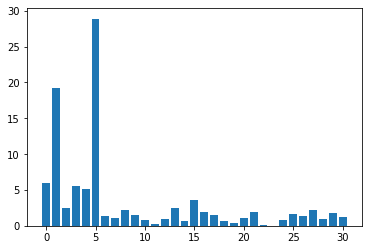

In [ ]:
# get feature importance for CBC model
importance = CBC.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
CatBoostImportance = FeatureImportance(importance.tolist())
printDataWithValue(CatBoostImportance)

1. Avg_Sentence_Length [5]: 28.899509096442234
2. Negative [1]: 19.26604507156117
3. Neutral [0]: 5.982286272894401
4. Avg_Sentence_Duration [3]: 5.568544444275884
5. Avg_Word_Duration [4]: 5.17527609116798
6. RMS_Median [15]: 3.5835885612585874
7. RMS_Min [13]: 2.454700579589262
8. Positive [2]: 2.4237515273695345
9. MFCC_Max [27]: 2.2641453623210324
10. Amp_Env_Min [8]: 2.2317919855752564
11. ZCR_Avg [16]: 1.9038375998762262
12. Mel_Spec_Avg [21]: 1.884908241339821
13. MFCC_STD [29]: 1.8475742649298892
14. Mel_Spec_Median [25]: 1.6110677959748667
15. Amp_Env_STD [9]: 1.5320821475220834
16. ZCR_Max [17]: 1.442074129770889
17. MFCC_Avg [26]: 1.4242414567537633
18. Amp_Env_Avg [6]: 1.352325267837941
19. MFCC_Median [30]: 1.2632775546291302
20. ZCR_Median [20]: 1.142761499214018
21. Amp_Env_Max [7]: 1.0211613654138392
22. MFCC_Min [28]: 0.9404256615071651
23. RMS_Max [12]: 0.8973830476078726
24. Mel_Spec_STD [24]: 0.8708299174016576
25. Amp_Env_Median [10]: 0.8299082369160944
26. ZCR_Min

### RandomForestClassifier

---



In [ ]:
rfc = RandomForestClassifier()

param_grid = {
    'n_estimators':[10,50,100,200,350,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [1,2,4,8,10,16,30,50,100],
    'criterion': ['gini', 'entropy']
}

rfc_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

rfc_grid.fit(x_train, y_train)

print("\nResults from Grid Search CatBoost:\n")
print(f"\n The best score across ALL searched params:\n{rfc_grid.best_score_}\n")
print(f"\n The best parameters across ALL searched params:\n{rfc_grid.best_params_}\n")

for Random Forest Classifier model:\Train Accuracy: 100.0 ; Test Accuracy: 86.35578583765113

Train Matrix:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1158
         1.0       1.00      1.00      1.00      1155

    accuracy                           1.00      2313
   macro avg       1.00      1.00      1.00      2313
weighted avg       1.00      1.00      1.00      2313


Test Matrix:
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.87       288
         1.0       0.88      0.84      0.86       291

    accuracy                           0.86       579
   macro avg       0.86      0.86      0.86       579
weighted avg       0.86      0.86      0.86       579




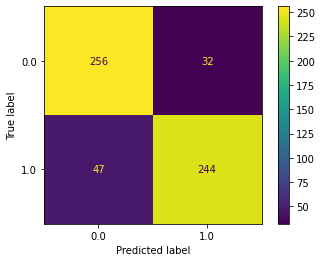

In [ ]:
# Random Forest Classifier Best Params : Classification-Report & Confusion-Matrix

rfc = RandomForestClassifier(criterion='gini',max_features='auto',max_depth=16,n_estimators=350)

rfc.fit(x_train, y_train)

rfc_predict_train = rfc.predict(x_train)
train_accuracy=accuracy_score(y_train,rfc_predict_train)*100

rfc_predict_test = rfc.predict(x_test)
test_accuracy=accuracy_score(y_test,rfc_predict_test)*100

print(f"for Random Forest Classifier model:\Train Accuracy: {train_accuracy} ; Test Accuracy: {test_accuracy}\n")

print(f"Train Matrix:\n{classification_report(y_train,rfc_predict_train)}\n")
print(f"Test Matrix:\n{classification_report(y_test,rfc_predict_test)}\n")

confusion_matrix = metrics.confusion_matrix(y_test,rfc_predict_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0.0, 1.0])

cm_display.plot()
plt.show()

Feature: 0, Score: 0.04450
Feature: 1, Score: 0.15673
Feature: 2, Score: 0.08633
Feature: 3, Score: 0.06143
Feature: 4, Score: 0.06594
Feature: 5, Score: 0.19666
Feature: 6, Score: 0.01617
Feature: 7, Score: 0.01254
Feature: 8, Score: 0.01600
Feature: 9, Score: 0.01623
Feature: 10, Score: 0.02047
Feature: 11, Score: 0.01698
Feature: 12, Score: 0.01747
Feature: 13, Score: 0.01204
Feature: 14, Score: 0.01566
Feature: 15, Score: 0.02598
Feature: 16, Score: 0.01805
Feature: 17, Score: 0.01705
Feature: 18, Score: 0.00623
Feature: 19, Score: 0.01672
Feature: 20, Score: 0.01138
Feature: 21, Score: 0.01748
Feature: 22, Score: 0.00475
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.02057
Feature: 25, Score: 0.01082
Feature: 26, Score: 0.01949
Feature: 27, Score: 0.02170
Feature: 28, Score: 0.01788
Feature: 29, Score: 0.01953
Feature: 30, Score: 0.01726


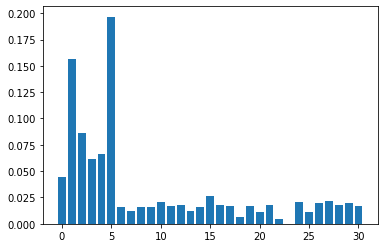

In [ ]:
# get feature importance for rfc model
importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
RFCImportance = FeatureImportance(importance.tolist())
printDataWithValue(RFCImportance)

1. Avg_Sentence_Length [5]: 0.19665658358960525
2. Negative [1]: 0.15672601897244468
3. Positive [2]: 0.08633222533709867
4. Avg_Word_Duration [4]: 0.06594426868234696
5. Avg_Sentence_Duration [3]: 0.06142513326564305
6. Neutral [0]: 0.044504196726853844
7. RMS_Median [15]: 0.025976673515743818
8. MFCC_Max [27]: 0.021698495261083885
9. Mel_Spec_STD [24]: 0.020571094733186884
10. Amp_Env_Median [10]: 0.020468932977231846
11. MFCC_STD [29]: 0.019525250266306828
12. MFCC_Avg [26]: 0.019487172014116975
13. ZCR_Avg [16]: 0.018047771808436544
14. MFCC_Min [28]: 0.017879134581785958
15. Mel_Spec_Avg [21]: 0.01748136456425639
16. RMS_Max [12]: 0.01746634991440931
17. MFCC_Median [30]: 0.0172610557803576
18. ZCR_Max [17]: 0.017047083724034264
19. RMS_Avg [11]: 0.016976527354303852
20. ZCR_STD [19]: 0.016715262692105805
21. Amp_Env_STD [9]: 0.01622511874800264
22. Amp_Env_Avg [6]: 0.016166374102957126
23. Amp_Env_Min [8]: 0.01600066739745716
24. RMS_STD [14]: 0.015659367110961418
25. Amp_Env_Max

# Neural Networks Feature Importance
Since in neural networks models the feature_importances_ property doesn't exist, we have to calculate the feature importance by ourselves.

After a wide variety of tests and many hardships, we came across a feature importance extraction method that after some adaptations, worked great for our MLPClassifier model.
The method's source is: https://romainlhardy.medium.com/estimating-feature-importance-the-easy-way-2ebe970c600c

And calculated by the following formula:
The importance of feature j is given by

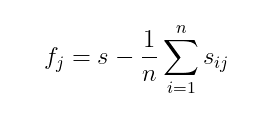

* This method was later refactored and re-used in order to do the same feature extraction method on our Keras Neural Network model.

### MLPClassifier
---

In [ ]:
# MLPClassifier (Neural Network) Hyperparameters tuning

clf_params = {'solver': ['lbfgs'],
              'max_iter': [2,4,8,10,20,50,100,200],
              'alpha': 10.0 ** -np.arange(1, 10),
              'hidden_layer_sizes':np.arange(10, 15),
             }

clf_grid = GridSearchCV(MLPClassifier(), clf_params, n_jobs=-1)

clf_grid.fit(x_train, y_train)

print("\nResults from Grid Search CatBoost:\n")
print(f"\n The best score across ALL searched params:\n{clf_grid.best_score_}\n")
print(f"\n The best parameters across ALL searched params:\n{clf_grid.best_params_}\n")

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


for MLPClassifier model:\Train Accuracy: 91.35322092520536 ; Test Accuracy: 90.32815198618307

Train Matrix:
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91      1158
         1.0       0.92      0.91      0.91      1155

    accuracy                           0.91      2313
   macro avg       0.91      0.91      0.91      2313
weighted avg       0.91      0.91      0.91      2313


Test Matrix:
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90       288
         1.0       0.90      0.91      0.90       291

    accuracy                           0.90       579
   macro avg       0.90      0.90      0.90       579
weighted avg       0.90      0.90      0.90       579




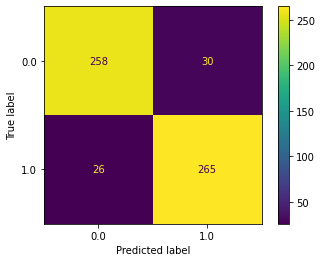

In [ ]:
# MLPClassifier Best Params : Classification-Report & Confusion-Matrix

mlp = MLPClassifier(alpha=0.001, hidden_layer_sizes=(11,),solver='lbfgs', max_iter=20)
mlp.fit(x_train, y_train)

mlp_predict_train = mlp.predict(x_train)
train_accuracy=accuracy_score(y_train,mlp_predict_train)*100

mlp_predict_test = mlp.predict(x_test)
test_accuracy=accuracy_score(y_test,mlp_predict_test)*100

print(f"for MLPClassifier model:\Train Accuracy: {train_accuracy} ; Test Accuracy: {test_accuracy}\n")

print(f"Train Matrix:\n{classification_report(y_train,mlp_predict_train)}\n")
print(f"Test Matrix:\n{classification_report(y_test,mlp_predict_test)}\n")

confusion_matrix = metrics.confusion_matrix(y_test,mlp_predict_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0.0, 1.0])

cm_display.plot()
plt.show()

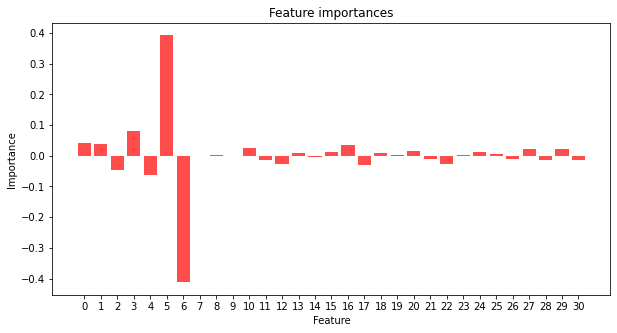

In [ ]:
# Feature Importance for MLP
def get_feature_importance(j, n):
  """
  Calculates the feature j importance.

  Args:
    j (int)- Feature j as explained in the formula above.
    n (int)- iterations of calculations and permutations.
  
  Returns:
    test_accuracy - as shown in the formula above.
  """
  global mlp_predict_test
  test_accuracy=accuracy_score(y_test,mlp_predict_test) # baseline score
  total = 0.0
  for i in range(n):
    perm = np.random.permutation(range(x_test.shape[0]))
    x_test_copy = x_test.copy()
    x_test_copy[:, j] = x_test[perm, j]
    mlp_predict_test = mlp.predict(x_test_copy)
    s_ij = accuracy_score(y_test, mlp_predict_test)
    total += s_ij
  return test_accuracy - total / n

features = []
for j in range(x_test.shape[1]):
  f_j = get_feature_importance(j, 100)
  features.append(f_j)
  features_indices = features.copy()
# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(x_test.shape[1]), features, color="r", alpha=0.7)
plt.xticks(ticks=range(x_test.shape[1]))
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.show()

---
# MLPClassifier Feature Importance
As this model had the best predictions results, we took the feature importance it produced with great attention.
Here's the list of the features with the most significant effect on the labels according to this model:

In [ ]:
MLPImportance = FeatureImportance(features)
printDataWithValue(MLPImportance)

1. Avg_Sentence_Length [5]: 0.3923143350604492
2. Avg_Sentence_Duration [3]: 0.0818825561312605
3. Neutral [0]: 0.041381692573402185
4. Negative [1]: 0.039222797927461195
5. ZCR_Avg [16]: 0.03585492227979281
6. Amp_Env_Median [10]: 0.025820379965457607
7. MFCC_STD [29]: 0.022797927461140177
8. MFCC_Max [27]: 0.02134715025906697
9. ZCR_Median [20]: 0.014663212435233275
10. RMS_Median [15]: 0.013333333333333086
11. Mel_Spec_STD [24]: 0.013195164075992749
12. ZCR_Min [18]: 0.010172711571675097
13. RMS_Min [13]: 0.01001727115716744
14. Mel_Spec_Median [25]: 0.0055613126079444575
15. ZCR_STD [19]: 0.0029706390328153587
16. Mel_Spec_Min [23]: 0.0017271157167525475
17. Amp_Env_Min [8]: 0.001088082901554377
18. Amp_Env_STD [9]: -0.0005699481865285572
19. Amp_Env_Max [7]: -0.002314335060448869
20. RMS_STD [14]: -0.003696027633851351
21. Mel_Spec_Avg [21]: -0.010172711571675763
22. MFCC_Avg [26]: -0.01120898100172707
23. MFCC_Min [28]: -0.01284974093264235
24. MFCC_Median [30]: -0.01309153713298

### Keras Neural Network

---



In [ ]:
# Keras Neural Network

def build_model():
  model = Sequential()
  model.add(Dense(12, input_shape=(31,), activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

from keras.wrappers.scikit_learn import KerasClassifier
keras_model = build_model()
keras_model.fit(x_train, y_train, epochs=30, batch_size=10)

_, accuracy = keras_model.evaluate(x_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/30
232/232 [==============================] - 1s 2ms/step - loss: 0.6009 - accuracy: 0.7034
Epoch 2/30
232/232 [==============================] - 1s 2ms/step - loss: 0.4203 - accuracy: 0.8271
Epoch 3/30
232/232 [==============================] - 1s 2ms/step - loss: 0.3630 - accuracy: 0.8482
Epoch 4/30
232/232 [==============================] - 1s 4ms/step - loss: 0.3387 - accuracy: 0.8552
Epoch 5/30
232/232 [==============================] - 1s 4ms/step - loss: 0.3251 - accuracy: 0.8612
Epoch 6/30
232/232 [==============================] - 1s 5ms/step - loss: 0.3111 - accuracy: 0.8651
Epoch 7/30
232/232 [==============================] - 1s 3ms/step - loss: 0.3019 - accuracy: 0.8712
Epoch 8/30
232/232 [==============================] - 0s 2ms/step - loss: 0.2926 - accuracy: 0.8759
Epoch 9/30
232/232 [==============================] - 0s 2ms/step - loss: 0.2847 - accuracy: 0.8794
Epoch 10/30
232/232 [==============================] - 0s 2ms/step - loss: 0.2781 - accuracy: 0.8837

19/19 [==============================] - 0s 2ms/step
for Keras Neural Network model:\Train Accuracy: 92.47730220492866 ; Test Accuracy: 87.91018998272885

Train Matrix:
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92      1158
         1.0       0.92      0.93      0.92      1155

    accuracy                           0.92      2313
   macro avg       0.92      0.92      0.92      2313
weighted avg       0.92      0.92      0.92      2313


Test Matrix:
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       288
         1.0       0.89      0.87      0.88       291

    accuracy                           0.88       579
   macro avg       0.88      0.88      0.88       579
weighted avg       0.88      0.88      0.88       579




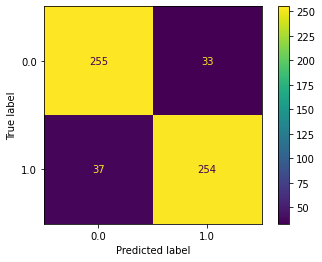

In [ ]:
# Predictions
keras_predict_train = (keras_model.predict(x_train) > 0.5).astype(int)
train_accuracy=accuracy_score(y_train,keras_predict_train)*100

keras_predict_test = (keras_model.predict(x_test) > 0.5).astype(int)
test_accuracy=accuracy_score(y_test,keras_predict_test)*100

print(f"for Keras Neural Network model:\Train Accuracy: {train_accuracy} ; Test Accuracy: {test_accuracy}\n")

print(f"Train Matrix:\n{classification_report(y_train,keras_predict_train)}\n")
print(f"Test Matrix:\n{classification_report(y_test,keras_predict_test)}\n")

confusion_matrix = metrics.confusion_matrix(y_test,keras_predict_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0.0, 1.0])

cm_display.plot()
plt.show()

19/19 [==============================] - 0s 2ms/step


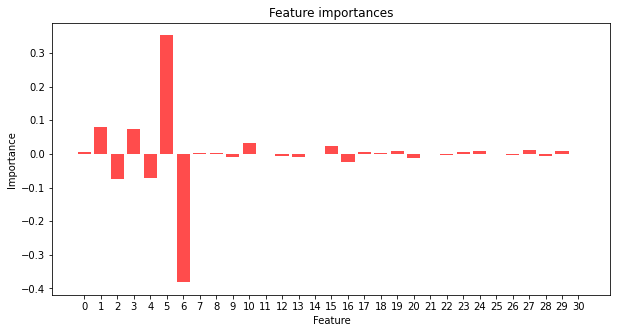

In [ ]:
def get_feature_importance(j, n):
  """
  Calculates the feature j importance.

  Args:
    j (int)- Feature j as explained in the formula above.
    n (int)- iterations of calculations and permutations.
  
  Returns:
    test_accuracy - as shown in the formula above.
  """
  global keras_predict_test
  test_accuracy = accuracy_score(y_test,keras_predict_test) # baseline score
  total = 0.0
  for i in range(n):
    perm = np.random.permutation(range(x_test.shape[0]))
    x_test_copy = x_test.copy()
    x_test_copy[:, j] = x_test[perm, j]
    keras_predict_test = (keras_model.predict(x_test_copy) > 0.5).astype(int)
    s_ij = accuracy_score(y_test, keras_predict_test)
    total += s_ij
  return test_accuracy - total / n

features = []
for j in range(x_test.shape[1]):
  f_j = get_feature_importance(j, 100)
  features.append(f_j)
  features_indices = features.copy()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(x_test.shape[1]), features, color="r", alpha=0.7)
plt.xticks(ticks=range(x_test.shape[1]))
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.show()

---


In [ ]:
KerasImportance = FeatureImportance(features)
printDataWithValue(KerasImportance)

1. Avg_Sentence_Length [5]: 0.3403972366148533
2. Negative [1]: 0.086666666666667
3. Avg_Sentence_Duration [3]: 0.046044905008635784
4. RMS_Avg [11]: 0.0386873920552675
5. Amp_Env_Median [10]: 0.027823834196891162
6. MFCC_Median [30]: 0.012469775474956757
7. ZCR_Median [20]: 0.011848013816925795
8. MFCC_STD [29]: 0.009671848013816597
9. Amp_Env_Min [8]: 0.007305699481865324
10. MFCC_Avg [26]: 0.00588946459412798
11. RMS_STD [14]: 0.005768566493954963
12. RMS_Min [13]: 0.004905008635578523
13. MFCC_Max [27]: 0.0035405872193432497
14. Mel_Spec_STD [24]: 0.0034887737478416225
15. Mel_Spec_Median [25]: 0.0030915371329878205
16. ZCR_Min [18]: 0.0010017271157168883
17. ZCR_STD [19]: -0.0001899827288429634
18. Mel_Spec_Min [23]: -0.0017271157167517703
19. RMS_Median [15]: -0.00302245250431743
20. Neutral [0]: -0.003816925734024479
21. ZCR_Avg [16]: -0.006770293609671962
22. Mel_Spec_Max [22]: -0.007875647668393326
23. Amp_Env_Max [7]: -0.012521588946459161
24. ZCR_Max [17]: -0.013195164075993

--- 
# AUC / ROC - Models Comparison
Finally, after training 5 different models and researching the feature importance in each of their results, we now want to compare the models and their results.

We use AUC/ROC graph in order to compare those models.




In [ ]:
pred_test_xgb = XGB.predict_proba(x_test)
pred_test_cbc = CBC.predict_proba(x_test)
pred_test_rfc = rfc.predict_proba(x_test)
pred_test_mlp = mlp.predict_proba(x_test)
pred_test_keras = keras_model.predict(x_test).ravel()


# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_test_xgb[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_test_cbc[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_test_rfc[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_test_mlp[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, pred_test_keras)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
auc_score1 = roc_auc_score(y_test, pred_test_xgb[:,1])
auc_score2 = roc_auc_score(y_test, pred_test_cbc[:,1])
auc_score3 = roc_auc_score(y_test, pred_test_rfc[:,1])
auc_score4 = roc_auc_score(y_test, pred_test_mlp[:,1])
auc_score5 = roc_auc_score(y_test, pred_test_keras)

print(auc_score1, auc_score2,auc_score3, auc_score4, auc_score5)

19/19 [==============================] - 0s 2ms/step
0.901847299458221 0.8979331248955823 0.9240733669061315 0.9435308718585169 0.9469319076827609


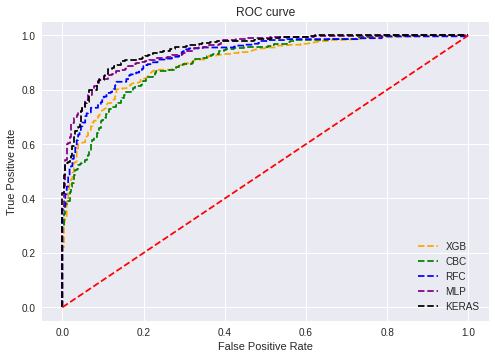

In [ ]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='XGB')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='CBC')
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='RFC')
plt.plot(fpr4, tpr4, linestyle='--',color='purple', label='MLP')
plt.plot(fpr5, tpr5, linestyle='--', color="black", label="KERAS")
plt.plot(p_fpr, p_tpr, linestyle='--', color='red')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

All the models have great results and are well trained, but MLPClassifier and Keras Neural Network came out as having the greatest calculation and training power and are highly recommended by us as the models that should have the focus on the upcoming progress of the research.

---
# Feature Importance - Final Presentation and Sorting
All that's left, is to compare the feature importance results from all the models and find out which features have the greatest impact on the status we labeled this dataset.

We decided to test 2 ways of sorting those feature importance results, since the neural networks results have negative scores as well, sorting by score might not be as accurate.

- The **first** list is sorted by **score**.
- The **second** list is sorted by **indices**.

In [ ]:
# Relevant Data
ModelsImportanceResults = [XGB_Importance, CatBoostImportance, RFCImportance, MLPImportance, KerasImportance]
Models = ["XGB", "CBC", "RFC", "MLP", "Keras"]
column_names = x_df.columns

In [ ]:
# Sort Feature Importance by SCORE
def overallFeatureImportanceByScore(cols, models):
  new_features = {}

  for feature in cols:
    new_features[feature] = 0

  for imp in models:
    for feature in imp:
      new_features[feature] += imp[feature]

  new_sorted_features = sortDictionaryDesc(new_features)

  return new_sorted_features
  
overallImportance = overallFeatureImportanceByScore(column_names, ModelsImportanceResults)
printDataWithValue(overallImportance)

1. Avg_Sentence_Length [5]: 36.111130366680854
2. Negative [1]: 34.91134020682961
3. Avg_Word_Duration [4]: 6.685172778144263
4. Mel_Spec_STD [24]: 2.344910953992112
5. Neutral [0]: 2.2787710951594247
6. Avg_Sentence_Duration [3]: 2.100216977013393
7. RMS_Median [15]: 1.8728466775775285
8. MFCC_STD [29]: 1.714821632051089
9. Mel_Spec_Avg [21]: 1.47528971772002
10. Positive [2]: 1.3465691759586575
11. MFCC_Min [28]: 1.2337467844409458
12. Amp_Env_Min [8]: 1.0333736527487187
13. Mel_Spec_Median [25]: 0.9169277920317033
14. RMS_Max [12]: 0.8868763595310486
15. ZCR_STD [19]: 0.7729113113669226
16. MFCC_Avg [26]: 0.6434199533465552
17. Amp_Env_Median [10]: 0.6386305305520048
18. MFCC_Median [30]: 0.6216184488605178
19. Amp_Env_Max [7]: 0.5005224698699944
20. RMS_Avg [11]: 0.5001172292135156
21. MFCC_Max [27]: 0.4955582038703884
22. RMS_Min [13]: 0.49282139412762377
23. RMS_STD [14]: 0.45410781234984005
24. ZCR_Min [18]: 0.42624979007207936
25. ZCR_Max [17]: 0.37695219237091243
26. Amp_Env_A

In [ ]:
# Sort Feature Importance by INDICES

def keysToList(dic):
  lst = []
  for k in dic.keys():
    lst.append(k)
  return lst

def overallFeatureImportanceByIndex(cols, models):

  new_features = {}

  for feature in cols:
    new_features[feature] = 0

  for imp in models:
    temp_imp_lst = keysToList(imp)
    for feature in temp_imp_lst:
      new_features[feature] += temp_imp_lst.index(feature)

  new_sorted_features = sortDictionaryAsc(new_features)

  return new_sorted_features


overallImportanceByIndex = overallFeatureImportanceByIndex(column_names, ModelsImportanceResults)
printDataNoValue(overallImportanceByIndex)

1. Avg_Sentence_Length [5]
2. Negative [1]
3. MFCC_STD [29]
4. RMS_Median [15]
5. Avg_Sentence_Duration [3]
6. Neutral [0]
7. Mel_Spec_STD [24]
8. Amp_Env_Min [8]
9. MFCC_Max [27]
10. Amp_Env_Median [10]
11. Avg_Word_Duration [4]
12. MFCC_Median [30]
13. MFCC_Avg [26]
14. Mel_Spec_Median [25]
15. ZCR_STD [19]
16. Mel_Spec_Avg [21]
17. MFCC_Min [28]
18. Amp_Env_Max [7]
19. RMS_Min [13]
20. RMS_STD [14]
21. ZCR_Median [20]
22. ZCR_Min [18]
23. Positive [2]
24. RMS_Avg [11]
25. Mel_Spec_Min [23]
26. RMS_Max [12]
27. ZCR_Max [17]
28. Mel_Spec_Max [22]
29. ZCR_Avg [16]
30. Amp_Env_STD [9]
31. Amp_Env_Avg [6]


In [ ]:
# Table of all Features in all models and their scores

def tableOfFeatures(cols, models, names):

  new_features = {}

  for feature in cols:
    new_features[feature] = []

  for imp in models:
    for feature in imp:
      new_features[feature].append(imp[feature])

  print(tabulate(new_features, headers='keys', tablefmt='fancy_grid',showindex=names))

tableOfFeatures(column_names, ModelsImportanceResults, Models)

╒═══════╤═════════════╤════════════╤════════════╤═════════════════════════╤═════════════════════╤═══════════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤══════════════════╤════════════╤════════════╤════════════╤════════════╤══════════════╤═════════════╤════════════╤════════════╤══════════════╤══════════════╤════════════════╤════════════════╤════════════════╤════════════════╤═══════════════════╤═════════════╤════════════╤════════════╤════════════╤═══════════════╕
│       │     Neutral │   Negative │   Positive │   Avg_Sentence_Duration │   Avg_Word_Duration │   Avg_Sentence_Length │   Amp_Env_Avg │   Amp_Env_Max │   Amp_Env_Min │   Amp_Env_STD │   Amp_Env_Median │    RMS_Avg │    RMS_Max │    RMS_Min │    RMS_STD │   RMS_Median │     ZCR_Avg │    ZCR_Max │    ZCR_Min │      ZCR_STD │   ZCR_Median │   Mel_Spec_Avg │   Mel_Spec_Max │   Mel_Spec_Min │   Mel_Spec_STD │   Mel_Spec_Median │    MFCC_Avg │   MFCC_Max │   MFCC_Min │   MFCC_STD │   MFCC_Median │
╞═

And the graph showing all features, all scores, in unsorted manner for each and every model we trained.